# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Изучение общей информации

Произведем проверку полученной таблицы, выведем полную информаци о ней, а также проверим значения в некоторых столбцах.

In [1]:
# импортируем библиотеку pandas, читаем файл с данными и сохраняем его в df
import pandas as pd
df = pd.read_csv('/datasets/data.csv')

In [2]:
# выводим общую информацию по таблице df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [3]:
# выведем описание таблицы для первичного анализа
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


In [4]:
# посчитаем количество пропущенных значений по таблице
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [5]:
# выводим первые 10 строк таблицы df
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Согласно документации к данным таблица имеет 12 столбцов:

* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

Наименования столбцов выполнены без нарушения стиля.

Далее разберем некоторые столбцы более подробно.

В столбце `days_employed` присутствуют отрицательные и аномально большие значения (артефакты).

In [6]:
# отфильтруем столбце days_employed по значениям больше 0 
# и после этого посчитаем уникальные значения в столбце income_type
df[df['days_employed'] > 0]['income_type'].value_counts()

пенсионер      3443
безработный       2
Name: income_type, dtype: int64

Артефакты в этих данных относяться только к пенсионерам и безработным. А для заемщиков, которые сейчас работают, значения стажа имеют отрицательный знак.

Затем проверим данные в столбце `children`:

In [7]:
# выведем данные по количеству уникальных значений в столбце children
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

В данных присутствуют отрицательные и завышенные значения количества детей.
С одной стороны возможно, что у заемщика может быть 20 детей, но с другой стороны это не единичный случай и отсутствуют данные от 5 и до 20 детей.

Таким же образом проверим столбец `dob_years`:

In [8]:
# выведем данные по уникальным значениям в столбце dob_years
df['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75])

В данных присутствуют нулевые значения возраста заемщика. Таков возможно при ошибочном заполнении анкет, либо вызваны программной ошибкой.

**Вывод**

В строках таблицы находятся данные о заемщиках, которые приобрели кредит в банке для определенных целей. В столбцах представленны данные о возрасте и поле, семейном положении (в том числе наличии детей), образовании, месте и стаже работы, а также о доходе и целях, на которые приобритался кредит.

Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Но встречаются пропуски в данных.

В данных выявлены следующие недостатки и артефакты:

* одинаковое количество пропущенных значений в столбцах `days_employed` и `total_income`
* в столбце `children` имеются отрицательные и завышенные значения
* данные в столбце `days_employed` представлены числами с плавающей точкой, а также имеют отрицательные и аномально большие значения (у пенсионеров и безработных)
* присутствуют нулевые значения возраста в столбце `dob_years`
* различные регистры написания данных столбца `education`, а также заглавный регистр в столбце `gender`
* в столбце `purpose` присутствуют одинаковые по смыслу, но различные по написанию, цели

## Предобработка данных

### Обработка пропусков

Как уже выяснили, пропуски данных имеются в столбцах `days_employed` и `total_income`. Что характерно, оба столбца имеют одинаковое количество пропусков в размере 2174 ячейки.

Возможно, пропущенные данные относятся к одним и тем же строкам.

In [9]:
# отфильтруем таблицу по пропущенным значениям в столбце days_employed
# в получившейся таблице посчитаем количество пропущенных значений
df[df['days_employed'].isna()].isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Отфильтровав таблицу по пропущенным значениям в столбце `days_employed`, мы увидели, что в столбце `total_income` точно такое же количество пропусков - 2174.

Из этого следует вывод, что пропущенные данные по общему стажу работы и доходу относятся к одним и тем же заемщикам.
Вероятно, указанные заемщики трудоустроены неофициально и не смогли предоставить подтверждающие документы по стажу и уровню ежемесячного дохода. Другой вероятной причиной появления пропусков может являться человеческий фактор - при заполнении заявки сотрудник банка забыл заполнить необходимые ячейки, либо произошла утеря копий документов.

Далее займемся заполнением пропущенных значений.

Первый столбец `days_employed` содержит в себе данные о количестве отработанных заемщиком дней, поэтому для заполнение пропусков сначала уберем отрицательные значения, поделим слишком большие значения на 24 часа, а затем возьмем среднее арифметическое значение по данному столбцу.

In [10]:
# убираем отрицательные значения из столбца days_employed используя метод .abs()
df['days_employed'] = df['days_employed'].abs()

In [11]:
# напишем функцию, которая поделит аномально высокие значения дней на 24 часа
def high_days_employed(days):
    """
    Функция возвращает аномально большое значение, деленное на 24 (количество часов в сутках) согласно правилу:
    если значение дней стажа больше 27740 (76 лет, максимальный возраст заемщика в датафрейме)
    """
    if days > 27740:
        return days / 24
    return days

# и выполним ее, заменив аномальные значения
df['days_employed'] = df['days_employed'].apply(high_days_employed)

In [12]:
# заполняем пропуски в столбце days_employed средним значением
df['days_employed'] = df['days_employed'].fillna(df['days_employed'].mean())

# старое решение
#df['days_employed'] = df['days_employed'].fillna(
#    df['days_employed'][df['days_employed'] <= df['dob_years'].max() * 365].mean())

Второй столбец `total_income` содержит в себе размер ежемесячного дохода заемщика. Для заполнения пропусков в данном столбце воспользуемся медианой.

In [13]:
# заполняем пропуски в столбце total_income медианным значением относительно каждого типа занятости
df['total_income'] = df['total_income'].fillna(df.groupby('income_type')['total_income'].transform('median'))

# старое решение
#df['total_income'] = df['total_income'].fillna(df['total_income'].median())

Устраним отрицательные и большие значения в столбце `children`:

In [14]:
# уберем отрицательные значения методом .abs()
df['children'] = df['children'].abs()

In [15]:
# изменим число детей 20 на 2
df.loc[df['children'] == 20, ['children']] = 2

Для проверки заполнения пропусков еще раз выведем информацию по таблице

In [16]:
# выводим общую информацию по таблице df для проверки отсутствия пропусков после их обработки
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

Выяснили несколько вероятных причин появления пропусков в данных - неофициальное трудоустройство заемщиков, либо человеческий фактор при заполнении заявок на кредит. Также заполнили пропуски в данных с помощью средних и медианных значений.

Устранили отрицательные значения в столбце данных с количеством детей. Возникновение данных артефактов возможно объяснить лишь с помощью программной или человеческой ошибки.

Теперь таблица полностью заполнена и готова для дальнейшей обработки

### Замена типа данных

Судя по информации, полученной из представленной таблицы, данные в столбце `days_employed` представленые типом float, числа с плавающей точкой. Но так как данные в указанном столбце представляют собой целочисленные значения - количество дней трудоустройства, то данные здесь должны иметь тип int.

In [17]:
# переводим типа данных столбца days_employed из float в int методом .astype()
df['days_employed'] = df['days_employed'].astype('int64')

Как уже было замечено ранее, в некоторых ячейках наблюдается различный регистр написания данных. Приведем строчные данные str к одинаковому нижнему регистру

In [18]:
# приведем столбцы education и gender к единому нижнему регистру методом .str.lower()
df['education'] = df['education'].str.lower()
df['gender'] = df['gender'].str.lower()

Изменим тип данных в столбце `total_income` с float на int, изменив значения общего дохода на целочисленные значения.

In [19]:
# переводим типа данных столбца total_income из float в int методом .astype()
df['total_income'] = df['total_income'].astype('int64')

**Вывод**

Заменили тип данных в количестве дней трудового стажа на целочисленные значения. Также привели строчные данные в столбцах обучения и пола к написанию нижним регистром.

### Обработка дубликатов

Ранее обработали строчные данные и привели их нижнему регистру, заполнили пропуски, теперь приступаем к удалению дубликатов:

In [20]:
# выведем общее количество дубликатов по таблице
df.duplicated().sum()

71

In [21]:
# удалим дубликаты строк методом .drop_duplicates() и обновим индексацию таблицы
df = df.drop_duplicates().reset_index(drop=True)

In [22]:
# выводим общую информацию по таблице df после очистки дубликатов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 12 columns):
children            21454 non-null int64
days_employed       21454 non-null int64
dob_years           21454 non-null int64
education           21454 non-null object
education_id        21454 non-null int64
family_status       21454 non-null object
family_status_id    21454 non-null int64
gender              21454 non-null object
income_type         21454 non-null object
debt                21454 non-null int64
total_income        21454 non-null int64
purpose             21454 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


**Вывод**

Обработав таблицу, удалили 71 дубликат. Появление дубликатов может быть связано с повтороными попытками заемщиков подать заявки на кредит, либо могли быть вызваны программным сбоем. 

### Лемматизация

Для того, чтобы в дальнейшем категоризировать цели кредитования, необходимо произвести лемматизацию столбца `purpose`. Сначала импортируем необходимый инструмент, а затем напишем функцию, которая будет производить лемматизацию целей. 

In [23]:
# импортируем инструмент для лемматизации Mystem из библиотеки pymystem3:
from pymystem3 import Mystem
m = Mystem()

In [24]:
# напишем функцию для лемматизации целей приобретения кредита
def purpose_group(row):
    """
    Функция производит лемматизацию столбца purpose
    с помощью метода lemmatize из библиотеки pymystem3.
    Лемматизация проходит по четырем основным наименованиям: 
    автомобиль, недвижимость, свадьба и образование
    """
    lem_purpose = m.lemmatize(row['purpose'])
    if 'автомобиль' in lem_purpose:
        return 'автомобиль'
    if ('недвижимость' in lem_purpose) or ('жилье' in lem_purpose):
        return 'недвижимость'
    if 'свадьба' in lem_purpose:
        return 'свадьба'
    if 'образование' in lem_purpose:
        return 'образование'

In [25]:
# применим вновь созданную функцию purpose_group к таблице и заполним данными новый столбец purpose_group
df['purpose_group'] = df.apply(purpose_group, axis=1)

**Вывод**

Создан новый столбец `purpose_group`, куда собраны обощенные цели кредитования с помощью функции лемматизации. Далее необходимо приступить к категоризации данных.

### Категоризация данных

Для ответа на поставленные вопросы, необходимы категории по следующим столбцам:
* `children` — количество детей в семье
* `family_status` — семейное положение
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

Так как `family_status` и `purpose` уже имеют категории, то следует создать их для двух оставшихся.

Сначала обработаем столбец `children`, создав новый столбец `children_group` для категорий заемщиков.

In [26]:
# напишем функцию для создания категорий по столбцу children
def children_group(children):
    """
    Функция возвращает группу по количеству детей children, используя правила:
    - 'нет детей', если children = 0 детей;
    - 'есть дети', если children >= 1
    """
    if children == 0:
        return 'нет детей'
    return 'есть дети' 

In [27]:
# выполним вновь созданную функцию children_group
df['children_group'] = df['children'].apply(children_group)

Далее обработаем столбец `total_income` и создадим новый столбец `income_group` для категорий:

In [28]:
# напишем функцию для создания категорий по столбцу total_income
def income_group(income):
    """
    Функция возвращает группу по значению дохода total_income, используя правила:
    - 'низкий доход', если total_income <= 50000 рублей;
    - 'средний доход', если total_income от 50001 до 100000 рублей;
    - 'высокий доход' — от 100001 и выше.
    """
    if income <= 50000:
        return 'низкий доход'
    if income <= 100000:
        return 'средний доход'
    return 'высокий доход' 

In [29]:
# выполним вновь созданную функцию income_group
df['income_group'] = df['total_income'].apply(income_group)

**Вывод**

С помощью функций добавили два новых столбца `children_group` и `income_group` для категоризации данных. В дальнейшем это необходимо для ответов на поставленные проектом вопросы.

Теперь данные полностью обработаны и готовы к выдаче результатов.

## Ответы на вопросы

Перед тем, как рассчитать необходимые зависимости, импортируем библиотеку Seaborn для визуализации полученных результатов.

In [30]:
# импортируем библиотеку seaborn для визуализации результатов
import seaborn as sns

### Зависимость между наличием детей и возвратом кредита в срок

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [32]:
# создадим свобдную таблицу с данными о наличии детей и задолженностями
children_pivot = df.pivot_table(
    index='children_group', 
    columns='debt', 
    values='children', 
    aggfunc='count')

# добавим столбец с процентным соотношенем "должников" по каждой категории
children_pivot['debt %'] = df.groupby(['children_group'])['debt'].mean() * 100
children_pivot

debt,0,1,debt %
children_group,,,
есть дети,6685,678,9.208203
нет детей,13028,1063,7.543822


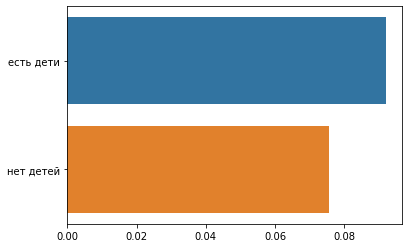

In [33]:
# назначим переменные для осей графиков
# x для среднего значения наличия задолженности заемщика по категориям
# y для уникальных значений категории наличия детей

x = [
    df[df['children_group'] == 'есть дети']['debt'].mean(),
    df[df['children_group'] == 'нет детей']['debt'].mean()
]
y = df['children_group'].unique()

# построим график по полученным результатам
sns.barplot(x=x, y=y)

**Вывод**

Зависимость показывает, что заемщики неимеющие детей реже имею задолженности по кредитованию, чем имеющие одного или более детей.

### Зависимость между семейным положением и возвратом кредита в срок

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [35]:
# создадим свобдную таблицу с данными о семейном положении и задолженностями
family_pivot = df.pivot_table(
    index='family_status', 
    columns='debt', 
    values='family_status_id', 
    aggfunc='count')

# добавим столбец с процентным соотношенем "должников" по каждой категории
family_pivot['debt %'] = df.groupby(['family_status'])['debt'].mean() * 100
family_pivot

debt,0,1,debt %
family_status,,,
Не женат / не замужем,2536,274,9.750890
в разводе,1110,85,7.112971
вдовец / вдова,896,63,6.569343
гражданский брак,3763,388,9.347145
женат / замужем,11408,931,7.545182


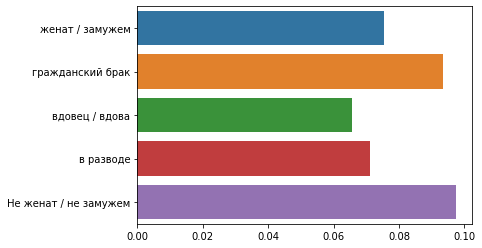

In [36]:
# назначим переменные для осей графиков
# x для среднего значения наличия задолженности заемщика по категориям
# y для уникальных значений семейного положения

x = [
    df[df['family_status'] == 'женат / замужем']['debt'].mean(),
    df[df['family_status'] == 'гражданский брак']['debt'].mean(),
    df[df['family_status'] == 'вдовец / вдова']['debt'].mean(),
    df[df['family_status'] == 'в разводе']['debt'].mean(),
    df[df['family_status'] == 'Не женат / не замужем']['debt'].mean()
]
y = df['family_status'].unique()

# построим график по полученным результатам
sns.barplot(x=x, y=y)

**Вывод**

В данном случае зависимость показывает, что овдовевшие заемщики реже всех имеют задолженности по кредитам. Затем идут заемщики в браке или уже разведенные. Хуже всех ситуация у несостоящих в браке или живущих в гражданском браке.

### Зависимость между уровнем дохода и возвратом кредита в срок

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [38]:
# создадим свобдную таблицу с данными об уровне дохода и задолженностями
income_pivot = df.pivot_table(
    index='income_group', 
    columns='debt', 
    values='total_income', 
    aggfunc='count')

# добавим столбец с процентным соотношенем "должников" по каждой категории
income_pivot['debt %'] = df.groupby(['income_group'])['debt'].mean() * 100
income_pivot

debt,0,1,debt %
income_group,,,
высокий доход,15604,1387,8.163145
низкий доход,349,23,6.182796
средний доход,3760,331,8.090931


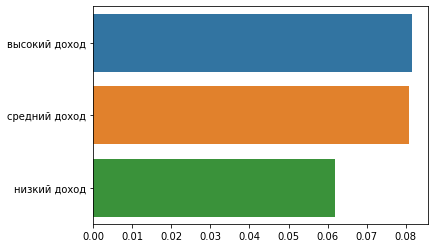

In [39]:
# назначим переменные для осей графиков
# x для среднего значения наличия задолженности заемщика по категориям
# y для уникальных значений категорий уровня дохода

x = [
    df[df['income_group'] == 'высокий доход']['debt'].mean(),
    df[df['income_group'] == 'средний доход']['debt'].mean(),
    df[df['income_group'] == 'низкий доход']['debt'].mean()
]
y = df['income_group'].unique()

# построим график по полученным результатам
sns.barplot(x=x, y=y)

**Вывод**

Тут зависимость показывает, что заемщики, имеющие доход менее 50000 рублей реже имеют задолженности по кредитам, чем заемщики, получающие более 50000 рублей.

### Зависимость разных целей кредитования и возвратом кредита в срок

- Как разные цели кредита влияют на его возврат в срок?

In [40]:
# старое решение с выводом среднего значения 

# сгруппируем данные по категориям целей кредитования и выделим их средние значения
# df.groupby(['purpose_group'])['debt'].mean()

In [41]:
# создадим свобдную таблицу с данными о целях кредита и задолженностями
purpose_pivot = df.pivot_table(
    index='purpose_group', 
    columns='debt', 
    values='purpose', 
    aggfunc='count')

# добавим столбец с процентным соотношенем "должников" по каждой категории
purpose_pivot['debt %'] = df.groupby(['purpose_group'])['debt'].mean() * 100
purpose_pivot

debt,0,1,debt %
purpose_group,,,
автомобиль,3903,403,9.359034
недвижимость,10029,782,7.233373
образование,3643,370,9.220035
свадьба,2138,186,8.003442


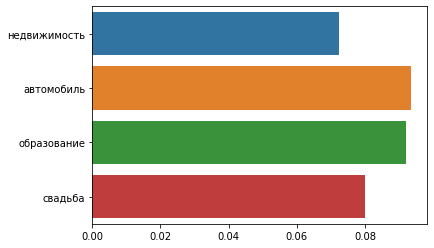

In [42]:
# назначим переменные для осей графиков
# x для среднего значения наличия задолженности заемщика по категориям
# y для уникальных значений категорий целей кредитования

x = [
    df[df['purpose_group'] == 'недвижимость']['debt'].mean(),
    df[df['purpose_group'] == 'автомобиль']['debt'].mean(),
    df[df['purpose_group'] == 'образование']['debt'].mean(),
    df[df['purpose_group'] == 'свадьба']['debt'].mean()
]
y = df['purpose_group'].unique()

# построим график по полученным результатам
sns.barplot(x=x, y=y)

**Вывод**

Зависимость показывает, что реже всего заемщики имеют задолженности при получении кредита на недвижимость, чуть чаще на свадьбу. На автомобиль и образование задолженности возникают чаще.

## Общий вывод

Для выполнение поставленных задач, мы предварительно обработали датафрейм, заполнили пропуски и удалили дубликаты. Изменили тип необходимых данных, провели лемматизацию целей и категоризацию интересующих нас столбцов.

Обработав подготовленные данные, мы увидели, какие категории заемщиков наиболее благонадежные:
* по наличию детей - бездетные
* по семейному положению - овдовевшие
* по общему доходу - имеющие доходи менее 50000 рублей
* по цели кредитование - на приобретение недвижимости